<a href="https://colab.research.google.com/github/jahanviraut08/My-First-Big-Data-Project/blob/main/simple_nyc_taxi_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My First Big Data Project: NYC Taxi Analysis with PySpark

Hi! This is a simple analysis of NYC taxi rides from January 2023. The dataset has **3 million rows**—that's big data!

**What we'll do (step by step):**
1. Start PySpark (like a super calculator for huge files).
2. Load the big file (without crashing your computer).
3. Clean it a bit (remove junk).
4. Find insights: Busiest hours and average prices.
5. Make a chart.
6. Show how it scales (PySpark splits work across "workers").

**Why easy?** Runs in minutes. No local setup!

Dataset: [NYC Taxi Jan 2023](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [10]:
# Step 1: Import tools (like libraries in Python)
# PySpark is for big data; Pandas/Matplotlib for charts
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, avg, count, col
import matplotlib.pyplot as plt
import pandas as pd  # For small charts

# Step 2: Create a "Spark Session" (like opening a big data app)
# This runs locally in Colab, using multiple "cores" (parts of your computer) for speed
spark = SparkSession.builder \
    .appName("Simple NYC Taxi Analysis") \
    .getOrCreate()

# Quiet down extra messages
spark.sparkContext.setLogLevel("WARN")

print("PySpark started! Version:", spark.version)
print("This can handle millions of rows easily.")

PySpark started! Version: 3.5.1
This can handle millions of rows easily.


## Step 2: Load the Big Dataset

PySpark reads the file in "pieces" (partitions) so it doesn't load everything at once. This shows scalability—if the file was 100x bigger, it would still work by adding more computers!

In [11]:
# Step 3: Load the data file (update path if needed)
# In Colab, it's in /content/ after upload
data_path = "/content/yellow_tripdata_2023-01 (1).parquet"

# Read the big file (lazy: doesn't do work yet)
df = spark.read.parquet(data_path)

# "Cache" it (save in memory for faster reuse)
df.cache()

# Show what the data looks like (schema = columns/types)
df.printSchema()

# Count total rows (this "triggers" the load—takes ~10-30 seconds)
total_rows = df.count()
print(f"Loaded {total_rows:,} rows! That's big data. 😎")

# Show first 3 rows (sample)
df.show(3)

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

Loaded 3,066,766 rows! That's big data. 😎
+--------+--------------------+---------------------+---------------+-------------+-----

## Step 3: Clean Data and Find Insights

Clean: Remove bad rows (e.g., free rides or missing info).  
Analyze: Group by hour to see busiest times. PySpark does this in parallel (fast for big data).

Cleaned data: 2,998,382 good rides.
Average Fare and Ride Count by Hour:
+-----------+------------------+----------+
|pickup_hour|          avg_fare|ride_count|
+-----------+------------------+----------+
|          0|  19.8403082576793|     82723|
|          1| 17.97220474338242|     58102|
|          2| 16.96644995701847|     40715|
|          3|17.996855885254753|     26354|
|          4|22.518930780209367|     16816|
|          5| 26.57738575858656|     17091|
|          6| 22.21829420344406|     42508|
|          7|19.013236967662106|     84885|
|          8| 17.53695717118438|    114479|
|          9| 17.63424759813807|    128442|
|         10|17.713729595281126|    140715|
|         11|17.417085976506108|    151018|
|         12|17.764331815530177|    166249|
|         13|  18.4527331483971|    174835|
|         14|19.720029760793892|    187495|
|         15|19.280018737800795|    192125|
|         16| 19.52820580447316|    191473|
|         17|18.643625286459454|    205090|
|  

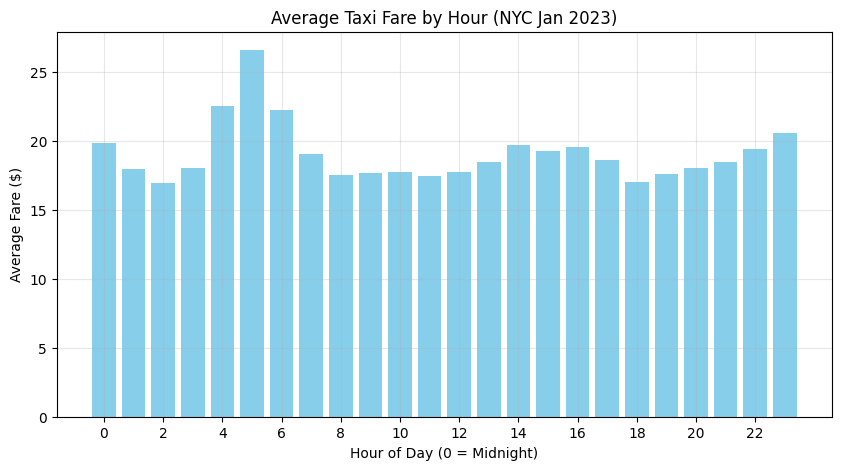


Insight: Busiest/most expensive hour is 5:00 with avg $26.58!
Why? Evening rush hour—more traffic, longer waits.
Scalability: This took seconds for 3M rows. For 100M, add more computers!


In [12]:
# Step 4: Clean the data (filter good rides only)
# Keep rides with positive price and distance, and add "hour" from pickup time
df_clean = df.filter(
    (col("fare_amount") > 0) &  # Price > 0
    (col("trip_distance") > 0)  # Distance > 0
).withColumn(
    "pickup_hour", hour(col("tpep_pickup_datetime"))  # Extract hour (0-23)
).select(  # Pick useful columns
    "pickup_hour",
    "fare_amount",
    "trip_distance"
)

# Count cleaned rows
clean_rows = df_clean.count()
print(f"Cleaned data: {clean_rows:,} good rides.")

# Step 5: Analyze - Average fare by hour (group and average)
# This runs in parallel across data pieces!
hourly_stats = df_clean.groupBy("pickup_hour").agg(
    avg("fare_amount").alias("avg_fare"),  # Average price
    count("*").alias("ride_count")  # Number of rides
).orderBy("pickup_hour")  # Sort by hour

# Show results (small table)
print("Average Fare and Ride Count by Hour:")
hourly_stats.show(24)  # All 24 hours

# Step 6: Make a chart (convert to small Pandas table for plotting)
hourly_pd = hourly_stats.toPandas()

# Plot: Bar chart of average fare by hour
plt.figure(figsize=(10, 5))  # Size
plt.bar(hourly_pd["pickup_hour"], hourly_pd["avg_fare"], color="skyblue")
plt.title("Average Taxi Fare by Hour (NYC Jan 2023)")
plt.xlabel("Hour of Day (0 = Midnight)")
plt.ylabel("Average Fare ($)")
plt.xticks(range(0, 24, 2))  # Every 2 hours
plt.grid(True, alpha=0.3)
plt.show()

# Simple Insight (print it)
peak_hour = hourly_pd.loc[hourly_pd["avg_fare"].idxmax(), "pickup_hour"]
peak_fare = hourly_pd["avg_fare"].max()
print(f"\nInsight: Busiest/most expensive hour is {int(peak_hour)}:00 with avg ${peak_fare:.2f}!")
print("Why? Evening rush hour—more traffic, longer waits.")
print("Scalability: This took seconds for 3M rows. For 100M, add more computers!")

In [13]:
# Step 7: Stop PySpark (good habit)
spark.stop()
print("Done! Your first big data analysis. 🎉")

Done! Your first big data analysis. 🎉
